# Import Modules
# Detector & Predictor

In [9]:
import dlib
from utils.aux_functions import *
import argparse
from matplotlib import pyplot as plt
import cv2
import glob

detector = dlib.get_frontal_face_detector() # 얼굴 좌표찾기 함수 (여러명도 가능)

path_to_dlib_model = "./dlib_models/shape_predictor_68_face_landmarks.dat"
if not os.path.exists(path_to_dlib_model):
    download_dlib_model()
    
predictor = dlib.shape_predictor(path_to_dlib_model) # 얼굴 랜드마크 68개 점 찾기

# Mask The side Face (correctly)

In [134]:
#def mask_the_face_correctly(face_image, mask_type):
def mask_the_face_correctly(face_image):    
    ##### 얼굴 좌표 찾기 #####
    face_locations = detector(face_image, 1) # return rectangles 객체 (여러명 얼굴인식)
    face_location = face_locations[0] # 1명만 얼굴인식
    
    
    ##### 얼굴 랜드마크별 68개 좌표 찾기 #####
    shape = predictor(face_image, face_location) # 68개 점 좌표
    shape = face_utils.shape_to_np(shape)
    face_landmarks = shape_to_landmarks(shape) # 얼굴 랜드마크별 68개의 점 좌표(groupby)
    face_location = rect_to_bb(face_location) # rectangles 객체를 튜플로 변환

    
    ##### 마스크를 씌울 6개의 얼굴좌표, 얼굴각도 #####
    six_points_on_face, angle = get_six_points(face_landmarks, face_image)  
    
    
    ##### 얼굴 각도 판단 후 어떤 마스크를 쓸것인지 선정 #####
    threshold = 12 # 얼굴각도 임계수치
    mask_type = "cloth"
    if abs(angle) > threshold:   #측면 사진인 경우
        if angle < -threshold:
            mask_type += "_right"
        elif angle > threshold:
            mask_type += "_left"
        
        str = mask_type
#     if not "empty" in mask_type and not "inpaint" in mask_type:
#         cfg = read_cfg(config_filename="masks/masks.cfg", mask_type=mask_type, verbose=False)
#     else:
#         if "left" in mask_type:
#             str = "surgical_left"
#         elif "right" in mask_type:
#             str = "surgical_right"

        cfg = read_cfg(config_filename="masks/masks.cfg", mask_type=str, verbose=False)   
    
        mask_image = cv2.imread(cfg.template, cv2.IMREAD_UNCHANGED) # cv2.IMREAD_UNCHANGED : 투명도인 Alpha 채널을 포함하여 원본 그대로 읽는다
        mask_dots = np.float32([cfg.mask_a, cfg.mask_b, cfg.mask_c, cfg.mask_f, cfg.mask_e, cfg.mask_d]) # 마스크 육각형 꼭지점 좌표
        #cfg = read_cfg(config_filename="./masks/masks.cfg", mask_type=mask_type, verbose=False)

        ##### 마스크 위치를 얼굴 위치(6개 좌표)와 동기화 #####
        M, mask = cv2.findHomography(mask_dots, six_points_on_face)
        w = face_image.shape[1] # 이미지 열 크기(가로)
        h = face_image.shape[0] # 이미지 행 크기(세로)
        dst_mask = cv2.warpPerspective(mask_image, M, (w, h))
        dst_mask_points = cv2.perspectiveTransform(mask_dots.reshape(-1, 1, 2), M)
        mask = dst_mask[:, :, 3]
    
    
        ##### 얼굴에 마스크 합성 #####    
        # Adjust Brightness
        mask_brightness = get_avg_brightness(mask_image)
        img_brightness = get_avg_brightness(face_image)
        delta_b = 1 + (img_brightness - mask_brightness) / 255
        dst_mask = change_brightness(dst_mask, delta_b)

        # Adjust Saturation
        mask_saturation = get_avg_saturation(mask_image)
        img_saturation = get_avg_saturation(face_image)
        delta_s = 1 - (img_saturation - mask_saturation) / 255
        dst_mask = change_saturation(dst_mask, delta_s)

        # Apply mask
        mask_inv = cv2.bitwise_not(mask)
        img_bg = cv2.bitwise_and(face_image, face_image, mask=mask_inv) # 얼굴이미지 마스크부분 배경제거(비트연산)
        img_fg = cv2.bitwise_and(dst_mask, dst_mask, mask=mask) # 마스크 이외 배경이미지 제거(비트연산)
        with_mask = cv2.add(img_bg, img_fg[:, :, 0:3])
        with_mask = cv2.cvtColor(with_mask, cv2.COLOR_BGR2RGB)

        return with_mask
    else:   #정면 사진인 경우
        return None

# Test

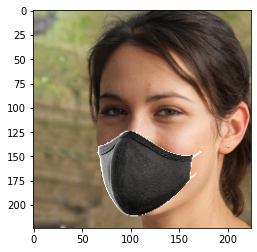

In [132]:
from numpy import uint8
image_path = '../kf99/images/color_imgs/seed1104.png' #1104

image = cv2.imread(image_path)                         # 사진 로드
face_image = image.copy()

resized_img = cv2.resize(face_image, (224, 224), interpolation = cv2.INTER_AREA)

result_img = mask_the_face_correctly(resized_img)

if type(result_img) == numpy.ndarray:
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    plt.imshow(result_img[:,:,::-1])

    cv2.imwrite('example_imgs/ex_output.jpg', result_img)
else:
    pass

# Mask The Face in Directory
## 측면 사진만 뽑아서 마스크 합성

In [136]:
import glob

img_path_list = glob.glob('../kf99/images/color_imgs/*.png')
print(len(img_path_list)) # 10000개

n = 0
for i, img_path in enumerate(img_path_list): 
    original_image = cv2.imread(img_path)
    face_image = original_image.copy()
    resized_image = cv2.resize(face_image, (224, 224), interpolation = cv2.INTER_AREA)

    try:
        result_mask = mask_the_face_correctly(resized_image)
        if type(result_mask) == numpy.ndarray:
            n += 1
            with_mask = cv2.cvtColor(result_mask, cv2.COLOR_BGR2RGB)
            new_img_path = './color_datasets_add_sideface/only_sideface/with_mask_' + str(n) + '.jpg' 
            cv2.imwrite(new_img_path, with_mask)
        else:
            pass
        
        if i % 500 == 0:
                print('complete:', img_path)

    except Exception as e:
        print('Error:', e, img_path) 

10000
complete: ../kf99/images/color_imgs/seed0000.png
complete: ../kf99/images/color_imgs/seed0500.png
complete: ../kf99/images/color_imgs/seed1000.png
complete: ../kf99/images/color_imgs/seed1500.png
complete: ../kf99/images/color_imgs/seed2000.png
complete: ../kf99/images/color_imgs/seed2500.png
complete: ../kf99/images/color_imgs/seed3000.png
complete: ../kf99/images/color_imgs/seed3500.png
complete: ../kf99/images/color_imgs/seed4000.png
complete: ../kf99/images/color_imgs/seed4500.png
complete: ../kf99/images/color_imgs/seed5000.png
complete: ../kf99/images/color_imgs/seed5500.png
complete: ../kf99/images/color_imgs/seed6000.png
complete: ../kf99/images/color_imgs/seed6500.png
complete: ../kf99/images/color_imgs/seed7000.png
complete: ../kf99/images/color_imgs/seed7500.png
complete: ../kf99/images/color_imgs/seed8000.png
complete: ../kf99/images/color_imgs/seed8500.png
complete: ../kf99/images/color_imgs/seed9000.png
complete: ../kf99/images/color_imgs/seed9500.png


# Mask The Face (incorrectly)

In [2]:
def mask_the_face_incorrectly(face_image, mask_type):
#def mask_the_face_incorrectly(face_image):    
    ##### 얼굴 좌표 찾기 #####
    face_locations = detector(face_image, 1) # return rectangles 객체 (여러명 얼굴인식)
    face_location = face_locations[0] # 1명만 얼굴인식
    
    
    ##### 얼굴 랜드마크별 68개 좌표 찾기 #####
    shape = predictor(face_image, face_location) # 68개 점 좌표
    shape = face_utils.shape_to_np(shape)
    face_landmarks = shape_to_landmarks(shape) # 얼굴 랜드마크별 68개의 점 좌표(groupby)
    face_location = rect_to_bb(face_location) # rectangles 객체를 튜플로 변환

    
    ##### 마스크를 씌울 6개의 얼굴좌표, 얼굴각도 #####
    six_points_on_face, angle = get_six_points(face_landmarks, face_image)  
    
    six_points_on_face_around = np.around(six_points_on_face)

    #print(six_points_on_face_around)

    face_a = six_points_on_face_around[0]
    face_b = six_points_on_face_around[1]
    face_c = six_points_on_face_around[2]
    face_f = six_points_on_face_around[3]
    face_e = six_points_on_face_around[4]
    face_d = six_points_on_face_around[5]

    a = (face_a[0]+face_d[0])/2
    b = (face_a[1]+face_d[1])/2.1
    face_a_2 = np.array([a,b])

    a = (face_b[0]+face_e[0])/2
    b = (face_b[1]+face_e[1])/2.1
    face_b_2 = np.array([a,b])

    a = (face_c[0]+face_f[0])/2
    b = (face_c[1]+face_f[1])/2.1
    face_c_2 = np.array([a,b])


    six_points_on_face = np.float32([face_a_2, face_b_2, face_c_2, face_f, face_e, face_d])
    
    ##### 얼굴 각도 판단 후 어떤 마스크를 쓸것인지 선정 #####
#     threshold = 13 # 얼굴각도 임계수치
#     mask_type = "KF94_0"
#     if angle < -threshold:
#         mask_type += "_right"
#     elif angle > threshold:
#         mask_type += "_left"
        
    cfg = read_cfg(config_filename="./masks/masks.cfg", mask_type=mask_type, verbose=False)
    mask_image = cv2.imread(cfg.template, cv2.IMREAD_UNCHANGED) # cv2.IMREAD_UNCHANGED : 투명도인 Alpha 채널을 포함하여 원본 그대로 읽는다
    mask_dots = np.float32([cfg.mask_a, cfg.mask_b, cfg.mask_c, cfg.mask_f, cfg.mask_e, cfg.mask_d]) # 마스크 육각형 꼭지점 좌표
    
    
    ##### 마스크 위치를 얼굴 위치(6개 좌표)와 동기화 #####
    M, mask = cv2.findHomography(mask_dots, six_points_on_face)
    w = face_image.shape[1] # 이미지 열 크기(가로)
    h = face_image.shape[0] # 이미지 행 크기(세로)
    dst_mask = cv2.warpPerspective(mask_image, M, (w, h))
    dst_mask_points = cv2.perspectiveTransform(mask_dots.reshape(-1, 1, 2), M)
    mask = dst_mask[:, :, 3]
    
    
    ##### 얼굴에 마스크 합성 #####    
    # Adjust Brightness
    mask_brightness = get_avg_brightness(mask_image)
    img_brightness = get_avg_brightness(face_image)
    delta_b = 1 + (img_brightness - mask_brightness) / 255
    dst_mask = change_brightness(dst_mask, delta_b)

    # Adjust Saturation
    mask_saturation = get_avg_saturation(mask_image)
    img_saturation = get_avg_saturation(face_image)
    delta_s = 1 - (img_saturation - mask_saturation) / 255
    dst_mask = change_saturation(dst_mask, delta_s)

    # Apply mask
    mask_inv = cv2.bitwise_not(mask)
    img_bg = cv2.bitwise_and(face_image, face_image, mask=mask_inv) # 얼굴이미지 마스크부분 배경제거(비트연산)
    img_fg = cv2.bitwise_and(dst_mask, dst_mask, mask=mask) # 마스크 이외 배경이미지 제거(비트연산)
    with_mask = cv2.add(img_bg, img_fg[:, :, 0:3])
    with_mask = cv2.cvtColor(with_mask, cv2.COLOR_BGR2RGB)
    
    return with_mask 

In [3]:
import glob

img_path_list = glob.glob('../kf99/images/color_imgs/*.png')
print(len(img_path_list)) # 10000개

mask_type_list = ['cloth', 'KF94_2', 'KF94_0', 'KN95', 'surgical', 'surgical_blue']
    
for i, img_path in enumerate(img_path_list): 
    original_image = cv2.imread(img_path)
    face_image = original_image.copy()
    resized_image = cv2.resize(face_image, (224, 224), interpolation = cv2.INTER_AREA)
    
    
    new_img_path = './color_datasets/no_mask/no_mask_' + str(i) + '.jpg' 
    cv2.imwrite(new_img_path, resized_image)
        

    try:
        if i < 1667:
            without_mask = mask_the_face_incorrectly(resized_image, mask_type_list[0])
            without_mask = cv2.cvtColor(without_mask, cv2.COLOR_BGR2RGB)
            new_img_path = './color_datasets/nose_mask/nose_mask_' + str(i) + '.jpg' 
            cv2.imwrite(new_img_path, without_mask)
        elif i < 3334:
            without_mask = mask_the_face_incorrectly(resized_image, mask_type_list[1])
            without_mask = cv2.cvtColor(without_mask, cv2.COLOR_BGR2RGB)
            new_img_path = './color_datasets/nose_mask/nose_mask_' + str(i) + '.jpg' 
            cv2.imwrite(new_img_path, without_mask)
        elif i < 5001:
            without_mask = mask_the_face_incorrectly(resized_image, mask_type_list[2])
            without_mask = cv2.cvtColor(without_mask, cv2.COLOR_BGR2RGB)
            new_img_path = './color_datasets/nose_mask/nose_mask_' + str(i) + '.jpg' 
            cv2.imwrite(new_img_path, without_mask)
        elif i < 6668:
            without_mask = mask_the_face_incorrectly(resized_image, mask_type_list[3])
            without_mask = cv2.cvtColor(without_mask, cv2.COLOR_BGR2RGB)
            new_img_path = './color_datasets/nose_mask/nose_mask_' + str(i) + '.jpg' 
            cv2.imwrite(new_img_path, without_mask)
        elif i < 8335:
            without_mask = mask_the_face_incorrectly(resized_image, mask_type_list[4])
            without_mask = cv2.cvtColor(without_mask, cv2.COLOR_BGR2RGB)
            new_img_path = './color_datasets/nose_mask/nose_mask_' + str(i) + '.jpg' 
            cv2.imwrite(new_img_path, without_mask)
        else:
            without_mask = mask_the_face_incorrectly(resized_image, mask_type_list[5])
            without_mask = cv2.cvtColor(without_mask, cv2.COLOR_BGR2RGB)
            new_img_path = './color_datasets/nose_mask/nose_mask_' + str(i) + '.jpg' 
            cv2.imwrite(new_img_path, without_mask)

        if i % 500 == 0:
            print('complete:', img_path)

        # 모든 예외의 에러 메시지를 출력할 때는 Exception을 사용
    except Exception as e:
        print('Error:', e, img_path) # ../Gray Scaled Classification/with_mask/with_mask_2663.jpg 오류

10000
complete: ../kf99/images/color_imgs/seed0000.png
complete: ../kf99/images/color_imgs/seed0500.png
complete: ../kf99/images/color_imgs/seed1000.png
complete: ../kf99/images/color_imgs/seed1500.png
complete: ../kf99/images/color_imgs/seed2000.png
complete: ../kf99/images/color_imgs/seed2500.png
complete: ../kf99/images/color_imgs/seed3000.png
complete: ../kf99/images/color_imgs/seed3500.png
complete: ../kf99/images/color_imgs/seed4000.png
complete: ../kf99/images/color_imgs/seed4500.png
complete: ../kf99/images/color_imgs/seed5000.png
complete: ../kf99/images/color_imgs/seed5500.png
complete: ../kf99/images/color_imgs/seed6000.png
complete: ../kf99/images/color_imgs/seed6500.png
complete: ../kf99/images/color_imgs/seed7000.png
complete: ../kf99/images/color_imgs/seed7500.png
complete: ../kf99/images/color_imgs/seed8000.png
complete: ../kf99/images/color_imgs/seed8500.png
complete: ../kf99/images/color_imgs/seed9000.png
complete: ../kf99/images/color_imgs/seed9500.png


(224, 224, 3)


True

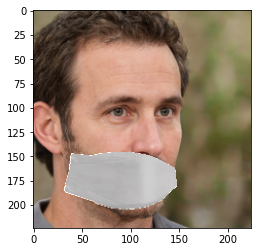

In [6]:
image_path = '../kf99/images/color_imgs/seed3468.png'

image = cv2.imread(image_path)                         # 사진 로드
face_image = image.copy()

resized_img = cv2.resize(face_image, (224, 224), interpolation = cv2.INTER_AREA)

result_img = mask_the_face_incorrectly(resized_img)

result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
print(result_img.shape)
plt.imshow(result_img[:,:,::-1])

cv2.imwrite('example_imgs/ex_output2.jpg', result_img)